In [1]:
# Temporary import. It will be removed in the final vserion
import os
import sys

import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import pytagi.metric as metric
from pytagi import Normalizer as normalizer
from pytagi import exponential_scheduler
from pytagi.nn import LSTM, Linear, Sequential
from pytagi.LSTM_KF_RL_Env import LSTM_KF_Env

from examples.data_loader import TimeSeriesDataloader, SyntheticTimeSeriesDataloader
from pytagi.hybrid import LSTM_SSM
from pytagi.hybrid import process_input_ssm

from src.RL_functions.dqn_lstm_agent import *

from itertools import count
import random

import copy

In [2]:
# Dataset
output_col = [0]
num_features = 2
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

# Network
net = Sequential(
    LSTM(num_features, 30, input_seq_len),
    LSTM(30, 30, input_seq_len),
    Linear(30 * input_seq_len, 1),
)
net.set_threads(8)
net.load(filename='./saved_param/HQ_hybrid_LSTM/lstm_hqts5_hybrid.pth')


phi_AA = 0.9999
Sigma_AR = 0.1**2
phi_AR = 0.86182671754275
Sigma_AA = Sigma_AR*1e-16
LA_var_stationary = Sigma_AA/(1-phi_AA**2)
AR_var_stationary = Sigma_AR /(1-phi_AR**2)
zB_init = np.array([-2.45233611e-01, 0.009008211652762738, 0, 0.05])
# # Autoregressive acceleration + online AR
hybrid = LSTM_SSM(
    neural_network = net,           # LSTM
    baseline = 'AA + plain_AR', # 'level', 'trend', 'acceleration', 'ETS'
    zB  = zB_init,    # initial mu for baseline hidden states
    SzB = np.array([1E-5, 1E-8, LA_var_stationary, Sigma_AR]),    # var
    phi_AA = phi_AA,
    phi_AR = phi_AR,
    Sigma_AR = Sigma_AR,
    Sigma_AA = Sigma_AA,
    use_online_AR = False,
)

ts_mean = np.array([-0.0340641, 26.5])
ts_std = np.array([0.14129518, 15.00833102])

In [3]:
train_dtl = TimeSeriesDataloader(
    x_file="data/HQ/hq_ts5_train.csv",
    date_time_file="data/HQ/hq_ts5_train_datetime.csv",
    x_mean=ts_mean,
    x_std=ts_std,
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year'
    # add_anomaly = True,
    # anomaly_magnitude=-0.0002,
    # anomaly_start=1500,
)

In [4]:
env = LSTM_KF_Env(render_mode=None, data_loader=train_dtl, \
                            ts_model=hybrid, step_look_back=64)
# env.ts_model.z[:-1]=zB_init.reshape(-1,1)
# init_z = np.copy(env.ts_model.z)
# init_z[0] = 1.4
# init_Sz = np.copy(env.ts_model.Sz)
# state, _ = env.reset(z=env.ts_model.z, Sz=env.ts_model.Sz)
state, _ = env.reset()

for t in count():
    action = 0
    # if t == 1500:
    #     action = 1
    state, reward, terminated, _, info = env.step(action)

    if terminated:
        break

In [5]:
mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()

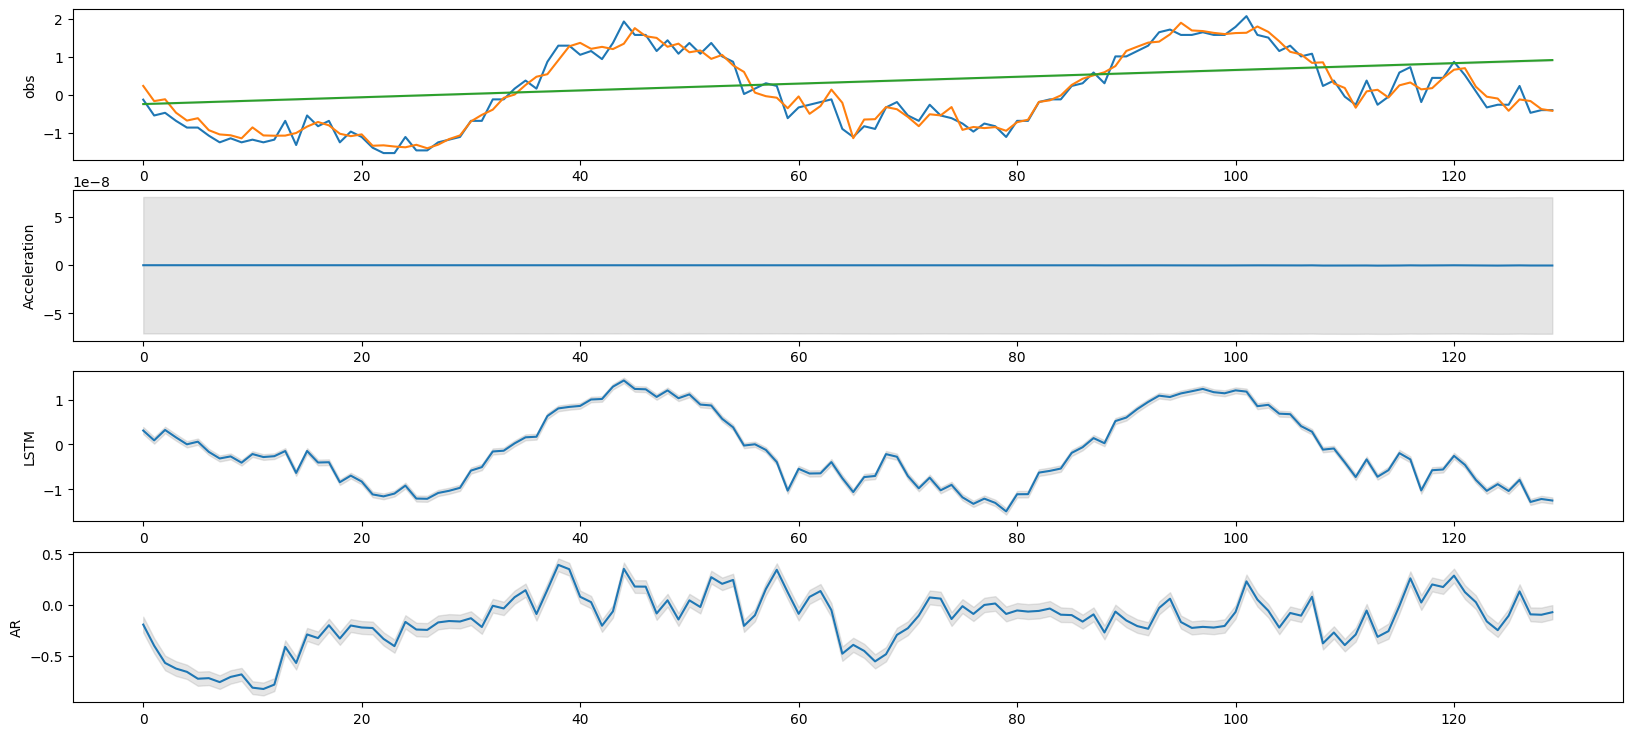

In [6]:
# Plot prediction
from matplotlib import gridspec
fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(4, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

time_step_indices = np.arange(0, len(mu_hidden_states_one_episode[:,2]), 1)

# Plot prediction
ax0.plot(time_step_indices, info['measurement_one_episode'], label='Observation')
ax0.plot(time_step_indices, mu_prediction_one_episode, label='Prediction')
# ax0.fill_between(
#     time_step_indices,
#     mu_prediction_one_episode - np.sqrt(var_prediction_one_episode),
#     mu_prediction_one_episode + np.sqrt(var_prediction_one_episode),
#     alpha=0.2,
#     color='gray',
# )
ax0.plot(time_step_indices, mu_hidden_states_one_episode[:,0], label='LL hidden state')
ax0.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,0] - np.sqrt(var_hidden_states_one_episode[:,0,0]),
    mu_hidden_states_one_episode[:,0] + np.sqrt(var_hidden_states_one_episode[:,0,0]),
    alpha=0.2,
    color='gray',
)
ax0.set_ylabel('obs')
# ax0.set_title('Synthetic time series')

# Plot AA hidden states
ax1.plot(time_step_indices, mu_hidden_states_one_episode[:,2], label='AA hidden state')
ax1.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,2] - np.sqrt(var_hidden_states_one_episode[:,2,2]),
    mu_hidden_states_one_episode[:,2] + np.sqrt(var_hidden_states_one_episode[:,2,2]),
    alpha=0.2,
    color='gray',
)
# ax1.set_ylim(-2e-8,2e-8)
ax1.set_ylabel('Acceleration')

# Plot LSTM hidden states
ax2.plot(time_step_indices, mu_hidden_states_one_episode[:,-1], label='LSTM hidden state')
ax2.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,-1] - np.sqrt(var_hidden_states_one_episode[:,-1,-1]),
    mu_hidden_states_one_episode[:,-1] + np.sqrt(var_hidden_states_one_episode[:,-1,-1]),
    alpha=0.2,
    color='gray',
)
ax2.set_ylabel('LSTM')

# Plot AR hidden states
ax3.plot(time_step_indices, mu_hidden_states_one_episode[:,-2], label='AR hidden state')
ax3.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]),
    mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]),
    alpha=0.2,
    color='gray',
)
ax3.set_ylabel('AR')
# ax3.set_ylim(-0.4,0.2)

plt.show()

In [7]:
# Get initial state from a stationary synthetic time series
init_z = copy.deepcopy(env.ts_model.z)
init_Sz = copy.deepcopy(env.ts_model.Sz)
init_mu_preds_lstm = copy.deepcopy(env.mu_preds_lstm)
init_var_preds_lstm = copy.deepcopy(env.var_preds_lstm)

train_dtl = SyntheticTimeSeriesDataloader(
    x_file="data/HQ/syn_dataset_hqts5_lstm_unstandardized_model1_200episodes.csv",
    select_column = 6,
    date_time_file="data/HQ/syn_dataset_hqts5_lstm_datetime.csv",
    x_mean=ts_mean,
    x_std=ts_std,
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year'
    # add_anomaly = True,
    # anomaly_magnitude=0.003,
    # anomaly_start=150,
)
env = LSTM_KF_Env(render_mode=None, data_loader=train_dtl, \
                ts_model=hybrid, step_look_back=64)

_, _ = env.reset(z=init_z, Sz=init_Sz, mu_preds_lstm = copy.deepcopy(init_mu_preds_lstm), var_preds_lstm = copy.deepcopy(init_var_preds_lstm))

for t in count():
    action = 0
    # if t == 350:
    #     action = 1
    _, _, terminated, _, info = env.step(action)

    if terminated:
        break

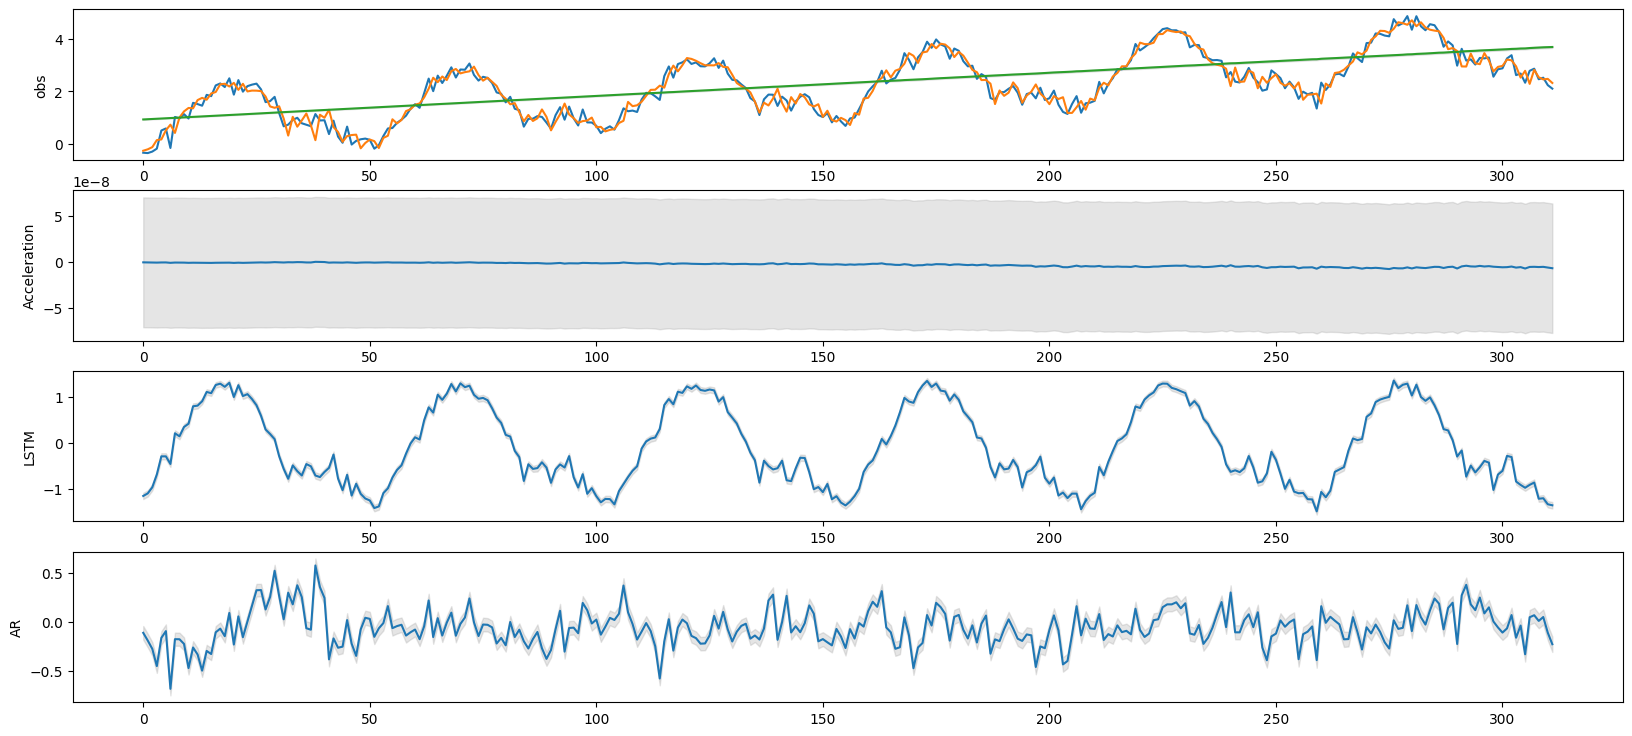

In [8]:
mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()
#  Plot prediction
from matplotlib import gridspec
fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(4, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

time_step_indices = np.arange(0, len(mu_hidden_states_one_episode[:,2]), 1)

# Plot prediction
ax0.plot(time_step_indices, info['measurement_one_episode'], label='Observation')
ax0.plot(time_step_indices, mu_prediction_one_episode, label='Prediction')
# ax0.fill_between(
#     time_step_indices,
#     mu_prediction_one_episode - np.sqrt(var_prediction_one_episode),
#     mu_prediction_one_episode + np.sqrt(var_prediction_one_episode),
#     alpha=0.2,
#     color='gray',
# )
ax0.plot(time_step_indices, mu_hidden_states_one_episode[:,0], label='LL hidden state')
ax0.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,0] - np.sqrt(var_hidden_states_one_episode[:,0,0]),
    mu_hidden_states_one_episode[:,0] + np.sqrt(var_hidden_states_one_episode[:,0,0]),
    alpha=0.2,
    color='gray',
)
ax0.set_ylabel('obs')
# ax0.set_title('Synthetic time series')

# Plot AA hidden states
ax1.plot(time_step_indices, mu_hidden_states_one_episode[:,2], label='AA hidden state')
ax1.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,2] - np.sqrt(var_hidden_states_one_episode[:,2,2]),
    mu_hidden_states_one_episode[:,2] + np.sqrt(var_hidden_states_one_episode[:,2,2]),
    alpha=0.2,
    color='gray',
)
# ax1.set_ylim(-2e-8,2e-8)
ax1.set_ylabel('Acceleration')

# Plot LSTM hidden states
ax2.plot(time_step_indices, mu_hidden_states_one_episode[:,-1], label='LSTM hidden state')
ax2.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,-1] - np.sqrt(var_hidden_states_one_episode[:,-1,-1]),
    mu_hidden_states_one_episode[:,-1] + np.sqrt(var_hidden_states_one_episode[:,-1,-1]),
    alpha=0.2,
    color='gray',
)
ax2.set_ylabel('LSTM')

# Plot AR hidden states
ax3.plot(time_step_indices, mu_hidden_states_one_episode[:,-2], label='AR hidden state')
ax3.fill_between(
    time_step_indices,
    mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]),
    mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]),
    alpha=0.2,
    color='gray',
)
ax3.set_ylabel('AR')
# ax3.set_ylim(-0.4,0.2)

plt.show()

In [9]:
# Read csv date_time_file
date_time_file = "data/HQ/syn_dataset_hqts5_lstm_datetime.csv"
date_time2 = pd.read_csv(date_time_file)
print(len(date_time2))

338


## Training

In [10]:
# Parameters relative to the environment
num_steps_per_episode = len(date_time2)
n_actions = env.action_space.n
n_observations = len(state['hidden_states'])
training_episodes = 200
step_look_back = 64
data_file_path = "data/HQ/syn_dataset_hqts5_lstm_unstandardized_model1_200episodes.csv"
date_time_file_path = "data/HQ/syn_dataset_hqts5_lstm_datetime.csv"
ts_model = hybrid
abnormal_ts_percentage = 0.5
anomaly_range = [-0.003, 0.003]
plot_samples = True
time_covariates = ['week_of_year']

# Parameters relative to the trainig of Q-Network
BATCH_SIZE = 128
GAMMA = 0.99            # discount factor
TAU = 0.005             # for soft update of target parameters
LR = 1e-4               # learning rate

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Complete


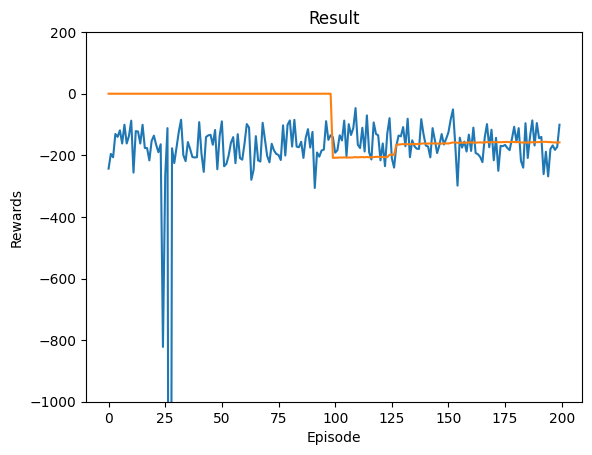

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

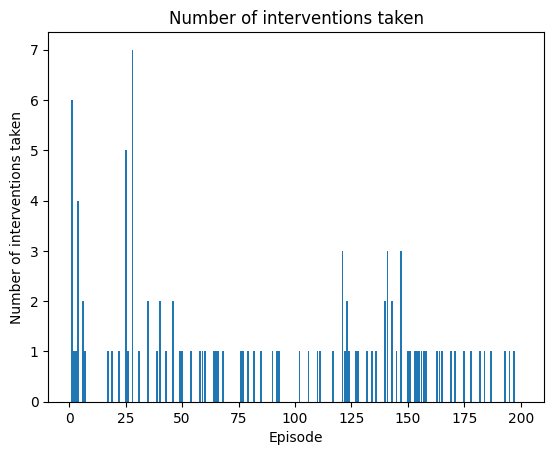

In [11]:
# Train the agent
agent = DQN_lstm_agent(n_observations, n_actions, device, LR, GAMMA)
agent.train(training_episodes, step_look_back, input_seq_len, num_steps_per_episode, \
            data_file_path, date_time_file_path, ts_model, ts_mean, ts_std,\
            abnormal_ts_percentage, anomaly_range, \
            init_z, init_Sz, init_mu_preds_lstm, init_var_preds_lstm, time_covariates,\
            BATCH_SIZE, TAU, plot_samples, learning_curve_ylim = [-1000, 200])

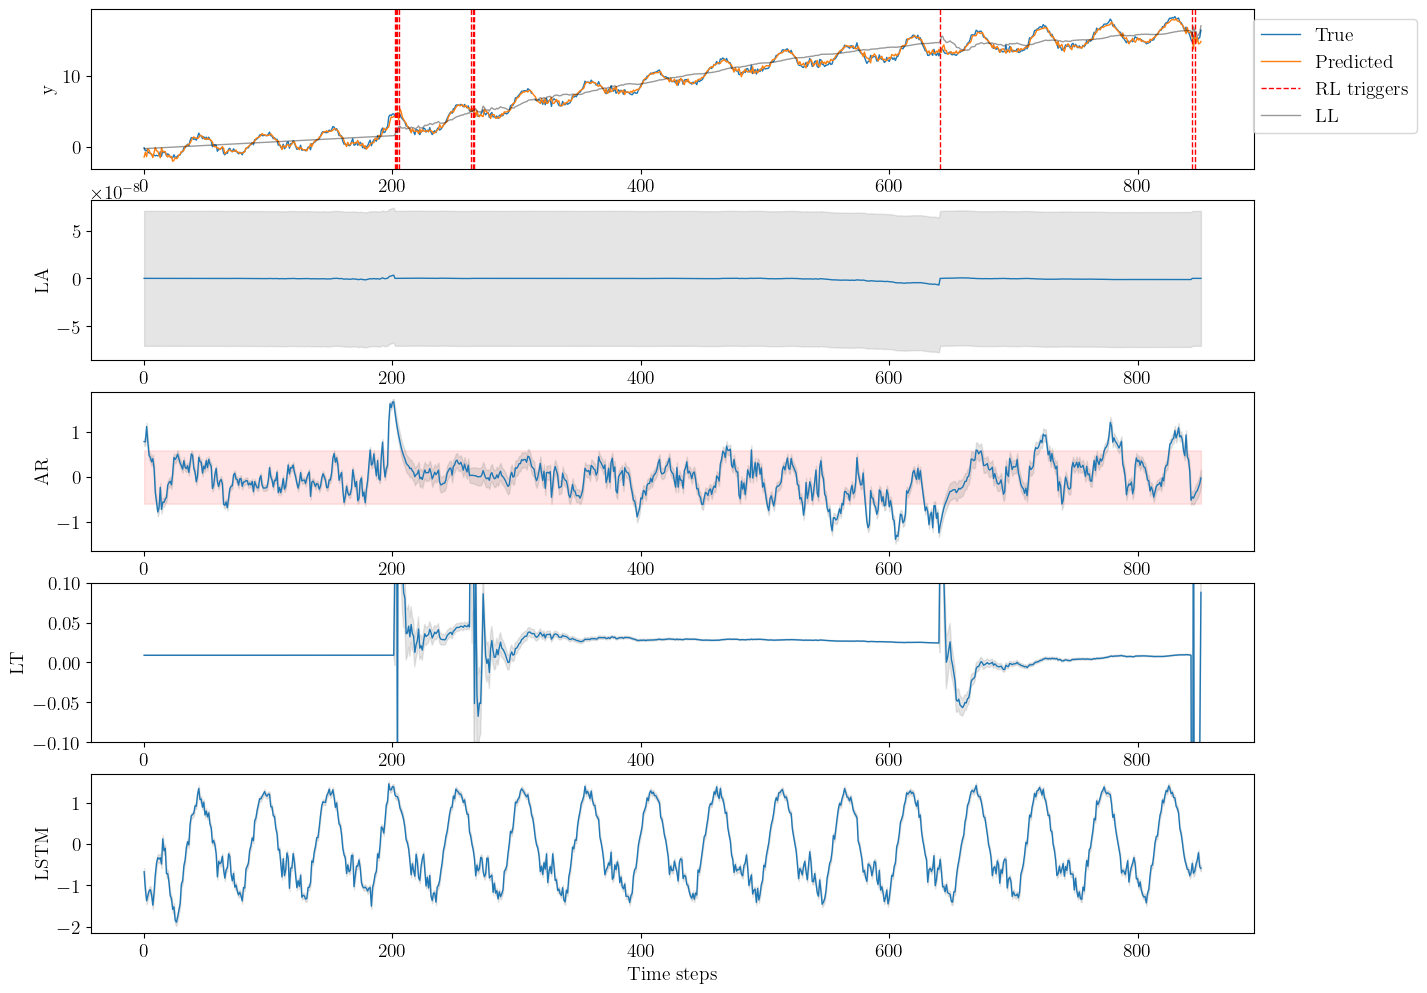

In [16]:
from itertools import count
zB_init = np.array([-2.45233611e-01, 0.009008211652762738, 0, 0.05])
# Sigma_AR = 0.1**2
# AR_var_stationary = Sigma_AR /(1-phi_AR**2)

hybrid = LSTM_SSM(
    neural_network = net,           # LSTM
    baseline = 'AA + plain_AR', # 'level', 'trend', 'acceleration', 'ETS'
    zB  = zB_init,    # initial mu for baseline hidden states
    SzB = np.array([1E-5, 1E-8, LA_var_stationary, Sigma_AR]),    # var
    phi_AA = phi_AA,
    phi_AR = phi_AR,
    Sigma_AR = Sigma_AR,
    Sigma_AA = Sigma_AA,
    use_online_AR = False,
)

test_dtl = TimeSeriesDataloader(
    x_file="data/HQ/hq_ts5.csv",
    date_time_file="data/HQ/hq_ts5_datetime.csv",
    x_mean=ts_mean,
    x_std=ts_std,
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year'
    # add_anomaly = True,
    # anomaly_magnitude=-0.0000501,
    # # anomaly_magnitude=-0.00005,
    # anomaly_start=anomaly_pos,
)

env = LSTM_KF_Env(render_mode=None, data_loader=test_dtl, \
                    ts_model=hybrid, step_look_back=step_look_back)

state, info = env.reset()

intervention_index =[]
intervention_taken = False
# LA_var_stationary = ts_model.Sigma_AA/(1 - ts_model.phi_AA**2)
if step_look_back == 64:
    seg_len = 8
for t in count():
    state = torch.tensor(state['hidden_states'],\
                        dtype=torch.float32, device=device).unsqueeze(0)
    state = normalize_tensor_two_parts(state, 0, np.sqrt(LA_var_stationary),\
                                        0, np.sqrt(AR_var_stationary), seg_len)
    action = agent.select_action(state, greedy=True)
    action = action.item()

    state, reward, terminated, truncated, info = env.step(action)

    if action == 1:
        intervention_index.append(t + step_look_back + 1)
        intervention_taken = True

    done = terminated or truncated
    if done:
        break

# Plot prediction
timesteps = np.arange(0, len(info['measurement_one_episode']), 1)
mu_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['mu'])
var_hidden_states_one_episode = np.array(info['hidden_state_one_episode']['var'])
mu_prediction_one_episode = np.array(info['prediction_one_episode']['mu']).flatten()
var_prediction_one_episode = np.array(info['prediction_one_episode']['var']).flatten()
from matplotlib import gridspec
fig = plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(5, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])


ax0.plot(timesteps, info['measurement_one_episode'], label='True')
ax0.plot(timesteps, mu_prediction_one_episode , label='Predicted')
for count, i in enumerate(intervention_index):
    if count == 0:
        ax0.axvline(x=timesteps[i], color='r', linestyle='--', label='RL triggers')
    else:
        ax0.axvline(x=timesteps[i], color='r', linestyle='--')
ax0.plot(timesteps, mu_hidden_states_one_episode[:,0], color = 'k',alpha=0.4, label='LL')
# ax0.fill_between(timesteps, mu_hidden_states_one_episode[:,0] - np.sqrt(var_hidden_states_one_episode[:,0,0]),\
#                     mu_hidden_states_one_episode[:,0] + np.sqrt(var_hidden_states_one_episode[:,0,0]), color='gray', alpha=0.2)
ax0.set_ylabel('y')
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.07,1))


ax1.plot(timesteps, mu_hidden_states_one_episode[:,2], label='LA')
ax1.fill_between(timesteps, mu_hidden_states_one_episode[:,2] - np.sqrt(var_hidden_states_one_episode[:,2,2]),\
                    mu_hidden_states_one_episode[:,2] + np.sqrt(var_hidden_states_one_episode[:,2,2]), color='gray', alpha=0.2)
ax1.set_ylabel('LA')

ax2.fill_between(timesteps, np.zeros_like(timesteps)-3*np.sqrt(AR_var_stationary), np.zeros_like(timesteps)+3*np.sqrt(AR_var_stationary), color='red', alpha=0.1)
ax2.plot(timesteps, mu_hidden_states_one_episode[:,-2], label='AR')
ax2.fill_between(timesteps, mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]),\
                    mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]), color='gray', alpha=0.2)
ax2.set_ylabel('AR')

ax3.plot(timesteps, mu_hidden_states_one_episode[:,1], label='LT')
ax3.fill_between(timesteps, mu_hidden_states_one_episode[:,1] - np.sqrt(var_hidden_states_one_episode[:,1,1]),\
                    mu_hidden_states_one_episode[:,1] + np.sqrt(var_hidden_states_one_episode[:,1,1]), color='gray', alpha=0.2)
ax3.set_ylabel('LT')
ax3.set_ylim(-0.1,0.1)

ax4.plot(timesteps, mu_hidden_states_one_episode[:,-1], label='LSTM')
ax4.fill_between(timesteps, mu_hidden_states_one_episode[:,-1] - np.sqrt(var_hidden_states_one_episode[:,-1,-1]),\
                    mu_hidden_states_one_episode[:,-1] + np.sqrt(var_hidden_states_one_episode[:,-1,-1]), color='gray', alpha=0.2)
ax4.set_ylabel('LSTM')
ax4.set_xlabel('Time steps')
plt.show()

In [13]:
plt.rcdefaults()

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    # line width
    "lines.linewidth": 1.0,
    })

from matplotlib import gridspec
fig = plt.figure(figsize=(6, 5))
gs = gridspec.GridSpec(5, 1, hspace=0.35)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

ax0.plot(timesteps, info['measurement_one_episode'], label='True')
ax0.plot(timesteps, mu_prediction_one_episode , label='Predicted')
for count, i in enumerate(intervention_index):
    if count == 0:
        ax0.axvline(x=timesteps[i], color='r', linestyle='--', label='RL triggers')
    else:
        ax0.axvline(x=timesteps[i], color='r', linestyle='--')
ax0.plot(timesteps, mu_hidden_states_one_episode[:,0], color = 'k',alpha=0.4, label='LL')
ax0.fill_between(timesteps, mu_hidden_states_one_episode[:,0] - np.sqrt(var_hidden_states_one_episode[:,0,0]),\
                    mu_hidden_states_one_episode[:,0] + np.sqrt(var_hidden_states_one_episode[:,0,0]), color='gray', alpha=0.2)
ax0.set_ylabel('y')
handles, labels = ax0.get_legend_handles_labels()
# ax0.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.15,1))
# remove xtick label from ax0 x axis
ax0.set_xticklabels([])

ax1.plot(timesteps, mu_hidden_states_one_episode[:,-1], label='LSTM')
ax1.fill_between(timesteps, mu_hidden_states_one_episode[:,-1] - np.sqrt(var_hidden_states_one_episode[:,-1,-1]),\
                    mu_hidden_states_one_episode[:,-1] + np.sqrt(var_hidden_states_one_episode[:,-1,-1]), color='gray', alpha=0.2)
ax1.set_ylabel('LSTM')
ax1.set_xticklabels([])

ax2.plot(timesteps, mu_hidden_states_one_episode[:,2], label='LA')
ax2.fill_between(timesteps, mu_hidden_states_one_episode[:,2] - np.sqrt(var_hidden_states_one_episode[:,2,2]),\
                    mu_hidden_states_one_episode[:,2] + np.sqrt(var_hidden_states_one_episode[:,2,2]), color='gray', alpha=0.2)
ax2.set_ylabel('acc.')
ax2.set_xticklabels([])

ax3.fill_between(timesteps, np.zeros_like(timesteps)-3*np.sqrt(AR_var_stationary), np.zeros_like(timesteps)+3*np.sqrt(AR_var_stationary), color='red', alpha=0.1)
ax3.plot(timesteps, mu_hidden_states_one_episode[:,-2], label='AR')
ax3.fill_between(timesteps, mu_hidden_states_one_episode[:,-2] - np.sqrt(var_hidden_states_one_episode[:,-2,-2]),\
                    mu_hidden_states_one_episode[:,-2] + np.sqrt(var_hidden_states_one_episode[:,-2,-2]), color='gray', alpha=0.2)
ax3.set_ylabel('res.')
ax3.set_xlabel('Time steps')

plt.savefig('RL_hqts2.png', dpi=1000)

In [14]:
date_time_file = "data/HQ/hq_ts5_datetime.csv"
real_date_time = pd.read_csv(date_time_file)
print(intervention_index[0])
for i in range(len(intervention_index)):
    print(real_date_time.values[intervention_index[i]+26])


202
['2010-08-15 12:00:00']
['2010-08-22 12:00:00']
['2010-08-29 12:00:00']
['2010-09-05 12:00:00']
['2011-10-16 12:00:00']
['2011-10-30 12:00:00']
['2011-11-06 12:00:00']
['2019-01-13 12:00:00']
['2022-12-04 12:00:00']
['2022-12-18 12:00:00']
